In [2]:
# get a trained model, a noisy piece of data, and feed the latter into the former
import sys
sys.path.append('..')


import os
from os import path
cwd = os.getcwd()
print(cwd)

import numpy as np
import random as rnd
#from keras.models import load_model
import librosa
# DSP functions such as applying noise, RIRs, or data representation conversions

import pandas as pd
import time
import scipy
import glob

# generate seed from the time at which this script is run
rnd.seed(int(time.time()))
import matplotlib.pyplot as plt 

# from libs.processing import s_to_reim, reim_to_s, make_fragments, unmake_fragments
from libs.processing import s_to_reim, reim_to_s, make_fragments, unmake_fragments, pink_noise, white_noise, velvet_noise
from libs.utilities import load_autoencoder_lossfunc, load_autoencoder_model, load_dataset

# # from scripts.denoise import denoise

/home/christie/SingleChannelDenoising_source/notebooks


Using TensorFlow backend.
/home/christie/miniconda3/envs/denoising/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# get a trained model, a noisy piece of data, and feed the latter into the former

# import os
# import numpy as np
# #from keras.models import load_model
# import librosa

# #from libs.data_generator import DataGenerator
# from libs.utilities import load_autoencoder_lossfunc, load_autoencoder_model
# #from libs.model_utils import LossLayer
# from libs.processing import s_to_reim, reim_to_s, make_fragments, unmake_fragments

def denoise(model_name, model_path, input_path, output_path,
        sr, n_fft, hop_length, win_length, frag_hop_length, frag_win_length, 
        batch_size):

    print('[n] Applying model {} at {} on data in {}'.format(model_name, model_path, input_path))
    print('[n] Denoising parameters: {}'.format({
        'model_name': model_name,
        'model_path': model_path,
        'input_path': input_path,
        'output_path': output_path,
    }))

    # set GPU devices
#     os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device

    ## Input data handling
    print('[dn] Loading data from {}...'.format(input_path))
    # load data from file name
    x_noisy, _ = librosa.core.load(input_path, sr=sr)
    # convert to TF-domain
    s = librosa.core.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # apply pre-processing (data representation)
    y_proc = s_to_reim(s)
    # split into fragments
    y_frags_noisy = make_fragments(y_proc, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    y_frags_noisy = np.array(y_frags_noisy)
    print('[dn] Generated {} fragments with shape {}'.format(len(y_frags_noisy), y_frags_noisy[0].shape))
    # Normalization per fragment
    std_frag = np.empty(len(y_frags_noisy))
    for i, yy in enumerate(y_frags_noisy):
        std_frag[i] = np.std(yy)
        yy = (yy - np.mean(yy))/std_frag[i]
    print('[dn] Normalized fragments with shape {}'.format( y_frags_noisy.shape))
    
    # load trained model
    print('[dn] Asking for loading model from {}...'.format(model_path))
    lossfunc = load_autoencoder_lossfunc(model_name)
    _, _, model = load_autoencoder_model(model_path, {'lossfunc': lossfunc})
    # print model summary
    #model.summary()

    # prediction on data
    print('[dn] Predicting with trained model...')
    y_frags_pred = model.predict(y_frags_noisy)
    print('[dn] Prediction finished!')

    ## Perform inverse operations on data
    # Inverse normalization
    for i, yy in enumerate(y_frags_pred):
        yy = yy *std_frag[i] # + np.mean(ss)
    # convert to complex spectrogram
    s_pred = reim_to_s(y_frags_pred)
    # undo batches
    s_pred = unmake_fragments(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    # get absolute spectrogram
    s_pred = np.abs(s_pred) ** 2
    # get waveform
    x_pred = librosa.istft(s_pred, hop_length=hop_length, win_length=win_length)
    
    # store cleaned audio as wav file
    librosa.output.write_wav(output_path, x_pred, sr=sr)

    # very slow at the beginning then very fast (real-time possible)
    #np.save('cleaned_data_pred', cleaned_data_pred)
    print('Cleaned data is reconstructed and stored at {}'.format(output_path))


    print('[dn] Done!')


In [4]:
def take_file_as_noise(filepath):
    # checking TODO
    print('Using the following file as noise: {0}'.format(filepath))
    # path = os.path.join(filepath + '.wav')
    
    load_noise =librosa.core.load(filepath)[0]
    print(load_noise.shape)
#     load_noise = glob.glob(filepath)

#     plt.plot(load_noise), plt.show()
    print(type(load_noise))
    def noising_prototype(x, SNR):
        N = np.max(x.shape)
#         print(N)
        sigma = np.sqrt( (x @ x.T) / (N * 10**(SNR/10)) )
#         print(sigma)
        print(np.mean(load_noise))
        noise =  sigma * (load_noise - np.mean(load_noise)) + np.mean(load_noise) 
        return noise
    return noising_prototype


In [ ]:
# x, sr = librosa.load(librosa.util.example_audio_file(),sr=16000)
# N = len(x)
# t = np.arange(0,N/sr,1/sr)
# snr = 0
# sigma = np.sqrt(x@(x.T)/(N*10**(snr/10)));
# x_noisy = x+ velvet_noise(x,snr)#x + [sigma* rnd.uniform(-.1,.1) for tt in range(len(t)) ]




In [5]:

noise = pink_noise

In [6]:
x, sr = librosa.core.load('/data/riccardo_datasets/cnn_news/newsday032213.wav', sr=10000)
print(x.shape)

(14912262,)


In [7]:
snr=0
x_noisy = x + noise(x,snr)#x + [sigma* rnd.uniform(-.1,.1) for tt in range(len(t)) ]
# (x.shape, x_noisy.shape)

Using pink noise


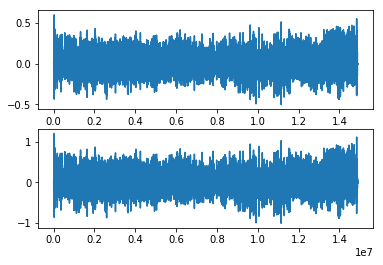

In [8]:
plt.subplot(2,1,1), plt.plot(x),
plt.subplot(2,1,2), plt.plot(x_noisy), 
plt.show()

In [9]:
n_fft = 512

hop_length = 256
win_length  =512

frag_hop_length= 256
frag_win_length=512

[n] Generated 226 fragments with shape (257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257

/home/christie/miniconda3/envs/denoising/lib/python3.6/site-packages/librosa/display.py:665: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)

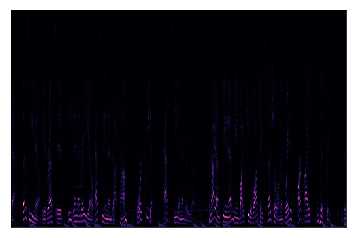

In [11]:
s = librosa.core.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=frag_win_length)

if_s_to_reim = False #True
# apply pre-processing (data representation)
y_proc = s_to_reim(s) if if_s_to_reim else s

# split into fragments
y_frags_noisy = make_fragments(y_proc, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
y_frags_noisy = np.array(y_frags_noisy)
print('[n] Generated {} fragments with shape {}'.format(len(y_frags_noisy), y_frags_noisy[0].shape))
librosa.display.specshow(y_frags_noisy[222,:,:])

# Normalization per fragment
std_frag = np.empty(len(y_frags_noisy))
for i, yy in enumerate(y_frags_noisy):
    print(yy.shape)
    std_frag[i] = np.std(yy)
    yy = (yy - np.mean(yy))/std_frag[i]
# print(y_frags_noisy[0,:,:,0], y_frags_noisy[0,:,:,1])
# print(np.mean(y_frags_noisy[0]))

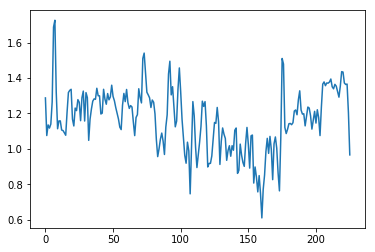

([<matplotlib.lines.Line2D at 0x7f40a5331f98>], None)

In [12]:
plt.plot(std_frag), plt.show()
# plt.plot(np.std(y_frags_noisy)), plt.show()

[n] Predicting with trained model...
[n] Prediction finished!


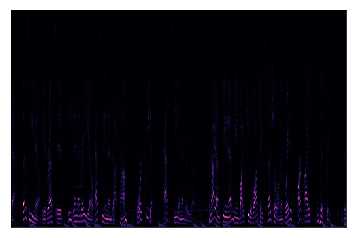

In [15]:
# s_noisy = librosa.core.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=frag_win_length)
# s_reim = s_to_reim(s_noisy)
# s_frag = make_fragments(s_reim, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)

# for i, yy in enumerate(s_frag):
#     yy = (yy - np.mean(yy))/std_frag[i]

    # prediction on data
print('[n] Predicting with trained model...')
y_frags_pred = y_frags_noisy# s_frag #to be simple, let just put the clean oe as the predicted one
print('[n] Prediction finished!')


librosa.display.specshow(y_frags_pred[222,:,:])
# plt.subplot(2,1,1), plt.plot(x),
# plt.subplot(2,1,2), plt.plot(x_noisy), plt.show()

In [16]:
## Perform inverse operations on data
# Inverse normalization
for i, yy in enumerate(y_frags_pred):
    print(yy.shape)
    yy = yy *std_frag[i] #+ np.mean(yy)
y_frags_pred = np.array(y_frags_pred)
print('y_frags_pred: ',y_frags_pred.shape)

# convert to complex spectrogram
s_pred = reim_to_s(y_frags_pred) if if_s_to_reim else y_frags_pred
# undo batches
s_pred = unmake_fragments(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)

# get absolute spectrogram
# s_pred = np.abs(s_pred) ** 2
# get waveform
x_pred = librosa.istft(s_pred, hop_length=hop_length, win_length=win_length)

(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)
(257, 512)

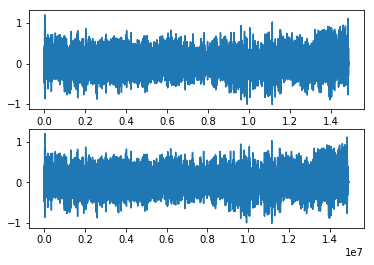

(1.2040523456422927, 1.2040524)

In [17]:
plt.subplot(2,1,1), plt.plot(x_pred),
plt.subplot(2,1,2), plt.plot(x_noisy), plt.show()
(np.max(x_noisy), np.max(x_pred))

In [ ]:
model_name='model_e12'
model_path = '/data/riccardo_models/denoising/model_e12.h5'
input_path = '/data/riccardo_datasets/npr_news/test/20180321_atc_decline_in_hunters_threatens_how_us_pays_for_conservation_.wav'
# mkdir('/data/riccardo_datasets/cnn_news/denoised')
output_path = '/data/riccardo_datasets/npr_news/denoised/'
batch_size = 32
# cuda_device

In [ ]:
denoise(model_name, model_path, input_path, output_path,
        sr, n_fft, hop_length, win_length, frag_hop_length, frag_win_length, 
        batch_size)